In [1]:
import time
import random
from pathlib import Path
import sys
import pandas as pd
import numpy
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw, PandasTools
from rdkit.Chem import rdFingerprintGenerator

In [2]:
sys.path.insert(0, '..')

In [3]:
morgan_gen = rdFingerprintGenerator.GetRDKitFPGenerator(minPath=5)

In [6]:
df = pd.read_csv('../data/csvs/ligand_acid_dataset.csv')

In [7]:
PandasTools.AddMoleculeColumnToFrame(df, 'Smiles', 'Mol')

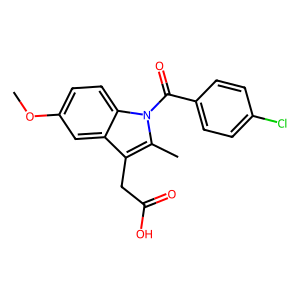

In [8]:
Draw.MolToImage(df.Mol[7])

In [9]:
df['fps'] = df.Mol.apply(morgan_gen.GetFingerprint)

In [10]:
df['fps'][1]

In [11]:
df.columns

Index(['Unnamed: 0', 'Molecule ChEMBL ID', 'Molecule Name', 'Molecular Weight',
       '#RO5 Violations', 'Smiles', 'Standard Value', 'Standard Units',
       'pChEMBL Value', 'Mol', 'COOH', 'fps'],
      dtype='object')

In [12]:
new_cols = ['ID'] + list(df.columns[1:])
df.columns = new_cols

In [13]:
def tanimoto_distance_matrix(fp_list):
    """Calculate distance matrix for fingerprint list"""
    dissimilarity_matrix = []
    # Notice how we are deliberately skipping the first and last items in the list
    # because we don't need to compare them against themselves
    for i in range(1, len(fp_list)):
        # Compare the current fingerprint against all the previous ones in the list
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

In [14]:
def butina_cluster(fps, threshold=0.5) -> None:
    """Cluster fingerprints with Butina"""
    triangular_matrix = tanimoto_distance_matrix(fps)
    clusters = Butina.ClusterData(triangular_matrix, len(fps), threshold, isDistData=True)
    return clusters

In [15]:
clusters = butina_cluster(df.fps)

In [16]:
import numpy as np
from scipy.stats import mode
ts = []
n_clusters = []

In [31]:
def cluster_stats(t, clusters):
    print('Threshold: ', t)
    print(f'Number of clusters: {len(clusters)}')
    n_clusters.append(len(clusters))
    print(f'Number of compounds: {len(compounds)}')
    clusters = sorted(clusters, key=len, reverse=True)
    print(
            f"Number of clusters: {len(clusters)} from {len(compounds)} molecules at distance cut-off {t:.2f}"
        )
    print("Number of molecules in largest cluster:", len(clusters[0]))
    print("Number of molecules in smallest cluster:", len(clusters[-1]))
    if len(clusters[-1]) == 1:
        print('Singletons: ', sum([1 for cluster in clusters if len(cluster) == 1]))
        print('Doubles: ', sum([1 for cluster in clusters if len(cluster) == 2]))
        print('Triples: ', sum([1 for cluster in clusters if len(cluster) == 3]))
    # calculate percentage of molecules clusters - all clusters expect singletons and doubles
    molecules_clustered = sum([len(cluster) for cluster in clusters if len(cluster) > 2])
    print('Percentage of molecules in clusters: ', (molecules_clustered / len(compounds)))
    print("Average cluster size:", np.mean([len(c) for c in clusters]))
    print("Median cluster size:", np.median([len(c) for c in clusters]))
    print('Mode cluster size:', mode([len(c) for c in clusters]))
    random_idx_1 = np.random.randint(0, len(clusters[0]))
    random_idx_2 = np.random.randint(0, len(clusters[0]))
    random_idx_3 = np.random.randint(0, len(clusters[1]))
    print(
            f"Similarity between two random points in same cluster: {DataStructs.TanimotoSimilarity(fingerprints[clusters[0][random_idx_1]], fingerprints[clusters[0][random_idx_2]]):.2f}"
        )
    print(
            f"Similarity between two random points in different cluster: {DataStructs.TanimotoSimilarity(fingerprints[clusters[0][random_idx_1]], fingerprints[clusters[1][random_idx_3]]):.2f}"
        )
    print('-------------------------------------')

In [32]:
for t in range(0, 80, 1):
    t = t / 100
    ts.append(t)
    clusters = butina_cluster(df.fps,t)
    compounds = df.Mol
    fingerprints = df.fps
    cluster_stats(t, clusters)
    if len(clusters) in range(98, 102):
        ideal = t

Threshold:  0.0
Number of clusters: 361
Number of compounds: 416
Number of clusters: 361 from 416 molecules at distance cut-off 0.00
Number of molecules in largest cluster: 6
Number of molecules in smallest cluster: 1
Singletons:  325
Doubles:  20
Triples:  15
Percentage of molecules in clusters:  0.12259615384615384
Average cluster size: 1.1523545706371192
Median cluster size: 1.0
Mode cluster size: ModeResult(mode=array([1]), count=array([325]))
Similarity between two random points in same cluster: 1.00
Similarity between two random points in different cluster: 0.28
-------------------------------------
Threshold:  0.01
Number of clusters: 352
Number of compounds: 416
Number of clusters: 352 from 416 molecules at distance cut-off 0.01
Number of molecules in largest cluster: 6
Number of molecules in smallest cluster: 1
Singletons:  313
Doubles:  22
Triples:  14
Percentage of molecules in clusters:  0.14182692307692307
Average cluster size: 1.1818181818181819
Median cluster size: 1.0
M

/tmp/ipykernel_59680/373483955.py:21: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  print('Mode cluster size:', mode([len(c) for c in clusters]))


Threshold:  0.02
Number of clusters: 337
Number of compounds: 416
Number of clusters: 337 from 416 molecules at distance cut-off 0.02
Number of molecules in largest cluster: 9
Number of molecules in smallest cluster: 1
Singletons:  291
Doubles:  30
Triples:  11
Percentage of molecules in clusters:  0.15625
Average cluster size: 1.2344213649851632
Median cluster size: 1.0
Mode cluster size: ModeResult(mode=array([1]), count=array([291]))
Similarity between two random points in same cluster: 1.00
Similarity between two random points in different cluster: 0.67
-------------------------------------
Threshold:  0.03
Number of clusters: 328
Number of compounds: 416
Number of clusters: 328 from 416 molecules at distance cut-off 0.03
Number of molecules in largest cluster: 9
Number of molecules in smallest cluster: 1
Singletons:  277
Doubles:  34
Triples:  11
Percentage of molecules in clusters:  0.17067307692307693
Average cluster size: 1.2682926829268293
Median cluster size: 1.0
Mode cluster

In [21]:
t  #0.44

0.79

In [22]:
ideal

0.45

(0.4, 0.47)

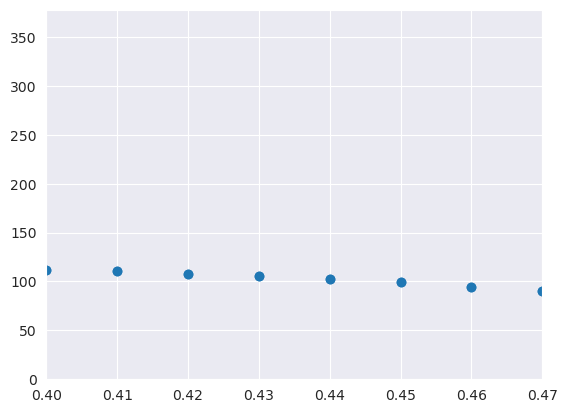

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.scatter(ts, n_clusters)
plt.xlim(0.4, 0.47)

In [33]:
clusters = butina_cluster(df.fps, 0.445)
len(clusters)

100

In [34]:
cluster_stats(0.445, clusters)

Threshold:  0.445
Number of clusters: 100
Number of compounds: 416
Number of clusters: 100 from 416 molecules at distance cut-off 0.45
Number of molecules in largest cluster: 119
Number of molecules in smallest cluster: 1
Singletons:  52
Doubles:  22
Triples:  4
Percentage of molecules in clusters:  0.7692307692307693
Average cluster size: 4.16
Median cluster size: 1.0
Mode cluster size: ModeResult(mode=array([1]), count=array([52]))
Similarity between two random points in same cluster: 0.65
Similarity between two random points in different cluster: 0.25
-------------------------------------


/tmp/ipykernel_59680/373483955.py:21: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  print('Mode cluster size:', mode([len(c) for c in clusters]))


In [41]:
selected_mols = []
np.random.seed(42)
for cluster in clusters:
    mol_id = np.random.choice(cluster, 1)
    selected_mols.append(mol_id[0])

In [42]:
selected_mols

[282,
 325,
 354,
 173,
 385,
 233,
 76,
 111,
 365,
 265,
 240,
 267,
 264,
 159,
 154,
 213,
 201,
 388,
 183,
 43,
 186,
 358,
 331,
 296,
 101,
 239,
 223,
 175,
 25,
 409,
 390,
 323,
 306,
 271,
 211,
 313,
 181,
 132,
 406,
 359,
 355,
 337,
 258,
 334,
 289,
 311,
 300,
 290,
 235,
 206,
 187,
 168,
 174,
 134,
 113,
 408,
 404,
 398,
 397,
 382,
 379,
 378,
 376,
 375,
 371,
 357,
 348,
 341,
 339,
 319,
 316,
 315,
 309,
 301,
 297,
 294,
 283,
 278,
 263,
 260,
 256,
 250,
 246,
 243,
 216,
 212,
 209,
 197,
 196,
 184,
 178,
 171,
 169,
 121,
 102,
 99,
 91,
 52,
 2,
 0]

In [43]:
subset = df[df.index.isin(selected_mols)]

In [44]:
subset.head(10)

,ID,Molecule ChEMBL ID,Molecule Name,Molecular Weight,#RO5 Violations,Smiles,Standard Value,Standard Units,pChEMBL Value,Mol,COOH,fps
0,1,CHEMBL134342,THIOCTIC ACID,206.33,0,O=C(O)CCCC[C@@H]1CCSS1,0.000,nM,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fa9f00565f0>,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,127,CHEMBL1077,BROMFENAC,334.17,0,Nc1c(CC(=O)O)cccc1C(=O)c1ccc(Br)cc1,4.803,nM,8.32,<rdkit.Chem.rdchem.Mol object at 0x7fa9f0056ac0>,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
25,337,CHEMBL1957450,NaN,394.45,1,N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](CS)C(=O...,15.000,nM,7.82,<rdkit.Chem.rdchem.Mol object at 0x7fa9efeb63c0>,1,"[0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, ..."
43,470,CHEMBL571,KETOPROFEN,254.29,0,CC(C(=O)O)c1cccc(C(=O)c2ccccc2)c1,26.000,nM,7.58,<rdkit.Chem.rdchem.Mol object at 0x7fa9efeb6900>,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
52,587,CHEMBL4781301,NaN,388.39,0,Cc1c(-c2nn(-c3ccccc3)cc2/C=N/O)nnn1-c1ccc(C(=O...,40.000,nM,7.40,<rdkit.Chem.rdchem.Mol object at 0x7fa9efeb6cf0>,1,"[1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, ..."
76,767,CHEMBL407368,NaN,289.76,0,Cc1ccc(Nc2c(C)cccc2Cl)c(CC(=O)O)c1,60.000,nM,7.22,<rdkit.Chem.rdchem.Mol object at 0x7fa9f0027c10>,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
91,847,CHEMBL4528493,NaN,362.43,0,CC(C)(C)OC(=O)N1CCC[C@H]1C(=O)N[C@@H](Cc1ccccc...,80.000,nM,7.10,<rdkit.Chem.rdchem.Mol object at 0x7fa9efed62e0>,1,"[0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, ..."
99,925,CHEMBL4636792,NaN,402.84,0,N[C@@H](Cc1cn(-c2nc(Cl)nc(N3CCOCC3)n2)c2ccccc1...,100.000,nM,7.00,<rdkit.Chem.rdchem.Mol object at 0x7fa9efed6660>,1,"[0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, ..."
101,933,CHEMBL1316,CARPROFEN,273.72,0,CC(C(=O)O)c1ccc2c(c1)[nH]c1ccc(Cl)cc12,100.000,nM,7.00,<rdkit.Chem.rdchem.Mol object at 0x7fa9efed6740>,1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
102,936,CHEMBL442441,NaN,353.21,0,C/C(=N/OCc1ccccc1Nc1c(Cl)cccc1Cl)C(=O)O,100.000,nM,7.00,<rdkit.Chem.rdchem.Mol object at 0x7fa9efed67b0>,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ..."


In [29]:
subset.to_csv('pocket_random_subset.csv', index=False)